Globally averaged temperature:

$$
\frac{dT}{dt} = R_i(T) -  R_0(T, C)
$$


$$
R_i(T) = \frac{Q_0}{c} (1 - p \alpha_\text{land} - p \alpha_\text{oc}(T)) 
$$

$$
R_o(T) = \frac{1}{c} (\kappa (T - T_\kappa) - a \ln (\frac{C}{C_0}) )
$$


Accumulated anthropogenic carbon, $S_a$
$$
\frac{d S_a}{dt} = C_a
$$

Atmospheric carbon concentration:

$$
\frac{dC}{dt} = v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))
$$

Temperature anomaly:
$$
\tilde{T} = T - T_{preindustrial}
$$



$$
\begin{align}
\delta \phi(\tilde{T}, C, S_a) =& \max_{C_a} \eta \log C_a  \\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d\tilde{T}} \left( R_i(T) - R_0(T, C) \right)\\
& + \frac{d\phi(\tilde{T}, C, S_a)}{d C} \left( v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))\right)\\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} C_a \\
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 \tilde{T}) (R_i(T) - R_0(T, C))
\end{align}
$$

$$
C_a^{*} = - \frac{ \eta}{\frac{d \phi (\tilde{T}, C, S_a)}{d C} + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} }
$$

In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import SymLogNorm
import matplotlib.mlab
import scipy.io as sio
import pandas as pd
import scipy.optimize as optim
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import fft, arange, signal
from scipy.interpolate import RegularGridInterpolator
import SolveLinSys
from supportfunctions import finiteDiff
rcParams["figure.figsize"] = (8,5)
                                                                                
def PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, 
              ε = 1, tol = -10):                                              
                                                                                 

    A = A.reshape(-1,1,order = 'F')                                         
    B = np.hstack([B1.reshape(-1,1,order = 'F'),B2.reshape(-1,1,order = 'F'),B3.reshape(-1,1,order='F')])
    C = np.hstack([C1.reshape(-1,1,order = 'F'),C2.reshape(-1,1,order = 'F'),C3.reshape(-1,1,order='F')])
    D = D.reshape(-1,1,order = 'F')                                         
    v0 = v0.reshape(-1,1,order = 'F')                                       
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)           

    return out                                                            

In [2]:
Bio = pd.read_csv("Bioefficiency.csv")

In [230]:
# Pre-industrial: 282.87K

sa = 1
Ts = 282.9
Cs = 275.5

Q0 = 342.5
p = 0.3
# outgoing radiation linearized
kappa = 1.74
Tkappa = 154
## CO2 radiative forcing
# Greenhouse effect parameter
B = 5.35

alphaland = 0.28
bP = 0.05
bB = 0.08
cod = 3.035
cearth = 10 #0.107
tauc = 20
coc0 =350
## Ocean albedo parameters
Talphaocean_low = 219
Talphaocean_high = 299
alphaocean_max = 0.84
alphaocean_min = 0.255

Cbio_low = 50
Cbio_high = 700

T0 = 298
C0 = 280

## CO2 uptake by vegetation
wa = 0.015
vegcover = 0.4

Thigh = 315
Tlow = 282
Topt1 = 295
Topt2 = 310
acc = 5

## Volcanism
Volcan = 0.028


def alphaocean(T):
    """T, matrix, (nT, nC, nF)"""
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = alphaocean_max
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = alphaocean_min

    return temp
    
#Fraction of ocean covered by ice
def fracseaice(T):
    
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = 1
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = 0

    return temp
    


def biopump(F):
    """F, accumulated anthrpogenic emission"""
    temp = np.zeros(F.shape)
    
    temp[F < Cbio_low] = 1
    temp[(F >= Cbio_low)&(F < Cbio_high)] = 1 - 1/(Cbio_high - Cbio_low) * (F[(F >= Cbio_low)&(F < Cbio_high)] - Cbio_low)
    temp[F >= Cbio_high] = 0
    return temp


def veggrowth(T):
    
    temp = np.zeros(T.shape)
    
    temp[T < Tlow] = 0
    temp[(T >= Tlow)&(T < Topt1)] = acc / (Topt1 - Tlow) * (T[(T >= Tlow)&(T < Topt1)] - Tlow)
    temp[(T >= Topt1)&(T < Topt2)] = acc
    temp[(T >= Topt2)&(T < Thigh)] = acc / (Topt2 - Thigh) * (T[(T >= Topt2)&(T < Thigh)] - Thigh)
    temp[T > Thigh] = 0
    
    return temp


#Incoming radiation modified by albedo
def Ri(T):
    return 1/cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(T)))

# Outgoing radiation modified by greenhouse effect
def Ro(T, C):
    return 1/cearth * (kappa * (T - Tkappa) -  B * np.log(C / C0))

#Solubility of atmospheric carbon into the oceans
# carbon pumps
def kappaP(T):
    return np.exp(-bP * (T - T0))

def oceanatmphysflux(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def oceanbioflux(T, F, sa):
    
    if sa == 1:
        
        return 1/tauc * (coc0 * (np.exp(bB * biopump(F) * (T - T0))))
    
    elif sa == 0:
        
        return 1/tauc * (coc0 * (np.exp(bB * (T - T0))))
    
    else:
        return ValueError("Wrong input value: 0 or 1.")

def oceanatmcorrflux(C):
    return 1 / tauc * (- cod * C)

In [231]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = 0. 
T_max  = 20. # 
hT     = 0.2
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in gigaton
C_min  = 250
C_max  = 500
hC     = 10
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton
F_min = 280. # 10. avaoid 
F_max = 2500. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 50.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(101, 26, 46)

In [232]:
To = 282.87 # Mean with no anthropogenic carbon emissions, in Fᵒ

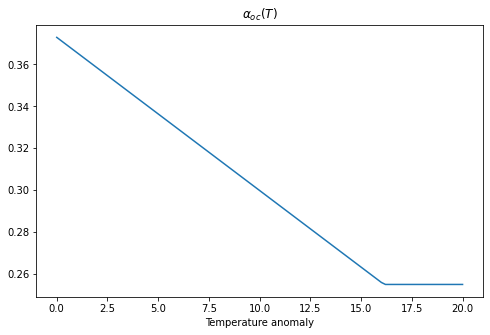

(0.255, 0.372950625)

In [233]:
α_ocean = alphaocean(T_grid + To)
plt.plot(T_grid, α_ocean)
plt.xlabel("Temperature anomaly")
plt.title("$α_{oc}(T)$")
plt.show()
α_ocean.min(), α_ocean.max()

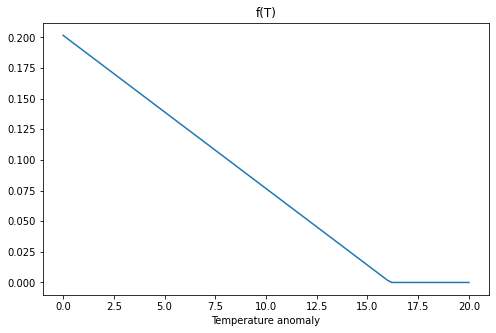

(0.0, 0.20162499999999994)

In [234]:
frac_sea_ice = fracseaice(T_grid + To)
plt.plot(T_grid, frac_sea_ice)
plt.xlabel("Temperature anomaly")
plt.title("f(T)")
plt.show()
frac_sea_ice.min(), frac_sea_ice.max()

In [235]:
frac_sea_ice.mean()

0.08150123762376228

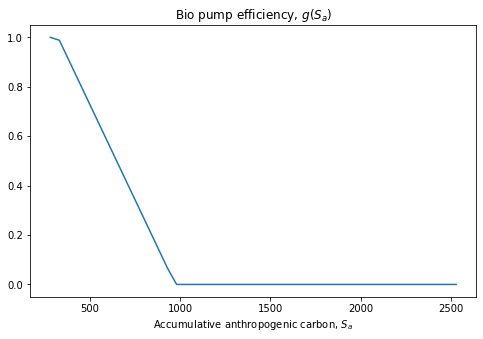

In [236]:
Fo = 272.3
bio_pump_efficiency = biopump(F_grid - Fo)
plt.plot(F_grid, bio_pump_efficiency)
plt.xlabel("Accumulative anthropogenic carbon, $S_a$")
plt.title("Bio pump efficiency, $g(S_a)$")
plt.show()

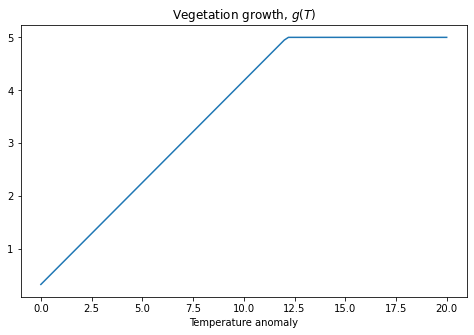

(0.33461538461538637, 5.0)

In [237]:
vege_growth = veggrowth(To + T_grid)


plt.plot(T_grid, vege_growth)
plt.xlabel("Temperature anomaly")
plt.title("Vegetation growth, $g(T)$")
plt.show()

vege_growth.min(), vege_growth.max()

In [238]:
vege_growth.mean()

3.576047220106627

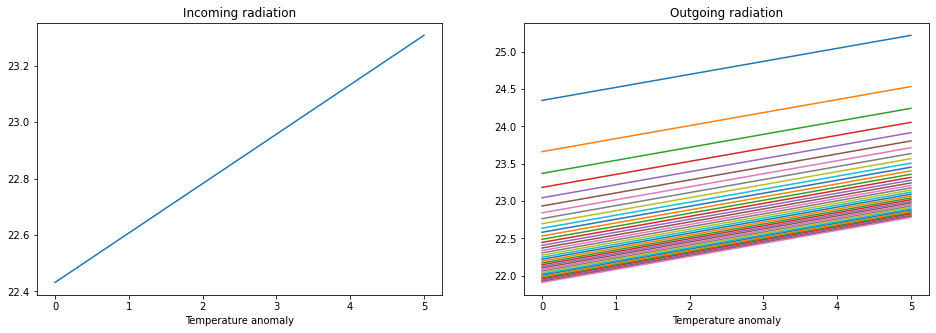

In [266]:
plt.subplots(1,2, figsize=(16, 5))
plt.subplot(121)

plt.title("Incoming radiation")
ri = Ri(To + T_grid)
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :] - Fo)
plt.plot(T_grid, ri)
plt.xlabel("Temperature anomaly")

plt.subplot(122)
plt.title("Outgoing radiation")
plt.plot(T_grid, ro)
plt.xlabel("Temperature anomaly")
plt.show()

Text(0.5, 0, 'Temperature anomaly')

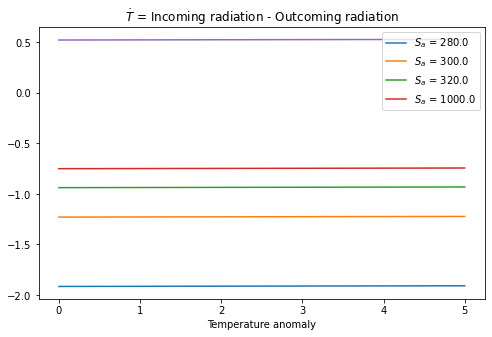

In [267]:
plt.title("$\\dot{T}$ = Incoming radiation - Outcoming radiation")
ri = Ri(To + T_mat[:, 0, :])
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :] - Fo)
plt.plot(T_grid, (ri - ro)[:, [0, 1,2,3, -1]])
plt.legend(["$S_a$ = {}".format(F) for F in F_grid[[0, 1, 2,-1]]])
plt.xlabel("Temperature anomaly")

In [241]:
T_grid[5], F_grid[17], C_grid[1]

(1.0, 1130.0, 260)

In [269]:
(ri - ro)[6, 17], 10 * 1.86/1000

(0.1255638738018412, 0.018600000000000002)

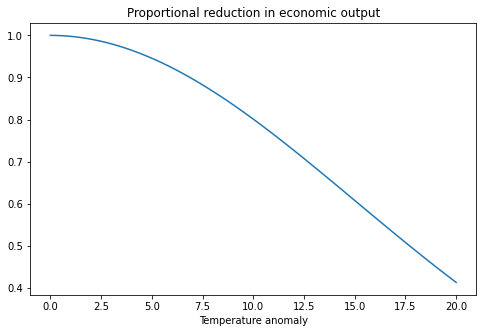

In [243]:
dG  = gamma_1 + gamma_2 * T_grid
G = gamma_1 * T_grid + gamma_2 / 2 * T_grid**2
plt.plot(T_grid, np.exp( -G) )
plt.xlabel("Temperature anomaly")
plt.title("Proportional reduction in economic output")
plt.show()

In [250]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = 0. 
T_max  = 5. # 
hT     = 0.2
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in gigaton
C_min  = 250
C_max  = 500.
hC     = 10.
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton
F_min = 280. # 10. avaoid 
F_max = 1000. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 20.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(26, 26, 37)

In [251]:
# v0 =  - eta * T_mat - eta * F_mat
v0 =  delta * eta * np.log(delta /4 * (9000/2.13 - F_mat)) + (eta - 1) * gamma_2 * T_mat / cearth * (B * np.log(C_mat/ C0) + kappa * (T_mat + To - Tkappa))

dG  = gamma_1 + gamma_2 * T_mat
epsilon  = 3.
count    = 0
error    = 1.
tol      = 1e-8
max_iter = 1000
fraction = 0.5


while error > tol and count < max_iter:
    
    dvdT  = finiteDiff(v0, 0, 1, hT)
    dvdTT = finiteDiff(v0, 0, 2, hT)
    dvdC  = finiteDiff(v0, 1, 1, hC)
#     dvdC[dvdC >= - 1e-16] = - 1e-16
    dvdCC = finiteDiff(v0, 1, 2, hC)
    dvdF  = finiteDiff(v0, 2, 1, hF)
    dvdFF = finiteDiff(v0, 2, 2, hF)
        

    Ca = - eta * delta / (dvdC + dvdF)

    Ca[Ca <= 1e-32] = 1e-32
    
    if count >=1:
        Ca = Ca * fraction + Ca_star * (1 - fraction)
    
#     Ca = np.ones(T_mat.shape)
    A  = - delta * np.ones(T_mat.shape)
    B1 = Ri(T_mat + To) - Ro(T_mat + To, C_mat)
    B2 = Volcan
    B2 += Ca * sa
    B2 -= wa * C_mat * vegcover * veggrowth(T_mat +To)
    B2 += oceanatmphysflux(T_mat + To)  * (1 - fracseaice(T_mat + To))
    B2 += oceanbioflux(T_mat + To, F_mat - Fo, sa) * (1 - fracseaice(T_mat + To))
    B2 += oceanatmcorrflux(C_mat) * (1 - fracseaice(T_mat + To))
    B3 = Ca
    C1 = 0. * np.ones(T_mat.shape)
    C2 = 0. * np.ones(T_mat.shape)
    C3 = np.zeros(T_mat.shape)
    D  = eta * delta * np.log(Ca) + (eta - 1) * dG * B1

    out = PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, epsilon)
    v = out[2].reshape(v0.shape, order="F")

    rhs_error = A * v0 + B1 * dvdT + B2 * dvdC + B3 * dvdF + C1 * dvdTT + C2 * dvdCC + C3 * dvdFF + D
    rhs_error = np.max(abs(rhs_error))
    lhs_error = np.max(abs((v - v0)/epsilon))

    error = lhs_error
    v0 = v
    Ca_star = Ca
    count += 1

    print("Iteration: %s;\t False Transient Error: %s;\t PDE Error: %s\t" % (count, lhs_error, rhs_error))

print("Total iteration: %s;\t LHS Error: %s;\t RHS Error %s\t" % (count, lhs_error, rhs_error))

Iteration: 1;	 False Transient Error: 0.07124473091282182;	 PDE Error: 0.034518266049943395	
Iteration: 2;	 False Transient Error: 0.03524383554067495;	 PDE Error: 0.043716326703566996	
Iteration: 3;	 False Transient Error: 0.05434211142191093;	 PDE Error: 0.06829336690354541	
Iteration: 4;	 False Transient Error: 0.01639615923364403;	 PDE Error: 0.08042963674220964	
Iteration: 5;	 False Transient Error: 0.01416172418738478;	 PDE Error: 0.2525091153244142	
Iteration: 6;	 False Transient Error: 0.015413930646204064;	 PDE Error: 0.1969448692043581	
Iteration: 7;	 False Transient Error: 0.012665635324420685;	 PDE Error: 0.10611580071258285	
Iteration: 8;	 False Transient Error: 0.012640622938217994;	 PDE Error: 0.048487648283003816	
Iteration: 9;	 False Transient Error: 0.012579429769251138;	 PDE Error: 0.03672601636255994	
Iteration: 10;	 False Transient Error: 0.012182429958360977;	 PDE Error: 0.021443660734324712	
Iteration: 11;	 False Transient Error: 0.011577515350395676;	 PDE Error:

Iteration: 89;	 False Transient Error: 0.007077502312300902;	 PDE Error: 0.3016515330578989	
Iteration: 90;	 False Transient Error: 0.012458356222407272;	 PDE Error: 2.635052658522994	
Iteration: 91;	 False Transient Error: 0.025746987455673775;	 PDE Error: 3.4763862633836635	
Iteration: 92;	 False Transient Error: 0.011670790327612146;	 PDE Error: 2.6683339826513173	
Iteration: 93;	 False Transient Error: 0.015724179716556663;	 PDE Error: 1.6496086468213607	
Iteration: 94;	 False Transient Error: 0.009764100510379495;	 PDE Error: 0.8066576570987887	
Iteration: 95;	 False Transient Error: 0.013370497117885497;	 PDE Error: 0.3235645617327469	
Iteration: 96;	 False Transient Error: 0.012518573840463084;	 PDE Error: 0.28888874858930025	
Iteration: 97;	 False Transient Error: 0.014813947044135209;	 PDE Error: 0.2082058267416033	
Iteration: 98;	 False Transient Error: 0.013015338377361898;	 PDE Error: 0.6432502007144025	
Iteration: 99;	 False Transient Error: 0.008453341379527338;	 PDE Erro

Iteration: 177;	 False Transient Error: 0.018176092539110216;	 PDE Error: 0.056516947065417	
Iteration: 178;	 False Transient Error: 0.017150969602586424;	 PDE Error: 0.034065105675239696	
Iteration: 179;	 False Transient Error: 0.014142366778618168;	 PDE Error: 0.05334110039195745	
Iteration: 180;	 False Transient Error: 0.009891320870949941;	 PDE Error: 0.37817235427520773	
Iteration: 181;	 False Transient Error: 0.007787590734508336;	 PDE Error: 0.4704326991788473	
Iteration: 182;	 False Transient Error: 0.0125494094134568;	 PDE Error: 0.3926446396105762	
Iteration: 183;	 False Transient Error: 0.037495010082928514;	 PDE Error: 0.28910726194755837	
Iteration: 184;	 False Transient Error: 0.04176913174200736;	 PDE Error: 0.5712365764092829	
Iteration: 185;	 False Transient Error: 0.031215479526757017;	 PDE Error: 0.2582920774756763	
Iteration: 186;	 False Transient Error: 0.020665502781720375;	 PDE Error: 0.12012458099797073	
Iteration: 187;	 False Transient Error: 0.0193760583960321

Iteration: 265;	 False Transient Error: 0.0472726580035533;	 PDE Error: 0.11373590340651887	
Iteration: 266;	 False Transient Error: 0.025393388553382763;	 PDE Error: 0.04878675320317592	
Iteration: 267;	 False Transient Error: 0.015768660771119786;	 PDE Error: 0.029727602089709586	
Iteration: 268;	 False Transient Error: 0.018432185234100323;	 PDE Error: 0.021527121610027955	
Iteration: 269;	 False Transient Error: 0.023818147276178647;	 PDE Error: 0.025839030903348797	
Iteration: 270;	 False Transient Error: 0.0306089928608466;	 PDE Error: 0.026045304260320777	
Iteration: 271;	 False Transient Error: 0.0637769792104847;	 PDE Error: 0.04234030836980115	
Iteration: 272;	 False Transient Error: 0.03029944189907176;	 PDE Error: 0.5746351856194938	
Iteration: 273;	 False Transient Error: 0.033644770373130205;	 PDE Error: 0.07726481748400331	
Iteration: 274;	 False Transient Error: 0.048852686406658706;	 PDE Error: 0.1695720318620255	
Iteration: 275;	 False Transient Error: 0.0165451187050

Iteration: 352;	 False Transient Error: 0.002978754218988059;	 PDE Error: 0.0031069824341926847	
Iteration: 353;	 False Transient Error: 0.002858735837770854;	 PDE Error: 0.0029800859702368452	
Iteration: 354;	 False Transient Error: 0.002745378958940503;	 PDE Error: 0.0028600064127736313	
Iteration: 355;	 False Transient Error: 0.002638411569390912;	 PDE Error: 0.0027465891113785225	
Iteration: 356;	 False Transient Error: 0.0025375046882205967;	 PDE Error: 0.002639562979580963	
Iteration: 357;	 False Transient Error: 0.002442306152142674;	 PDE Error: 0.0025385995820961463	
Iteration: 358;	 False Transient Error: 0.00235246021006541;	 PDE Error: 0.0024433470711214406	
Iteration: 359;	 False Transient Error: 0.0022676188003273867;	 PDE Error: 0.002353449861669807	
Iteration: 360;	 False Transient Error: 0.0021874479149307513;	 PDE Error: 0.002268559961370456	
Iteration: 361;	 False Transient Error: 0.0021116309886077453;	 PDE Error: 0.0021883433645276734	
Iteration: 362;	 False Transie

Iteration: 437;	 False Transient Error: 0.00040916549551256454;	 PDE Error: 0.00042426059135846744	
Iteration: 438;	 False Transient Error: 0.0004027834472288781;	 PDE Error: 0.00041775776895111734	
Iteration: 439;	 False Transient Error: 0.0003964991058060067;	 PDE Error: 0.00041135634406066276	
Iteration: 440;	 False Transient Error: 0.00039030874836842405;	 PDE Error: 0.0004050525234348359	
Iteration: 441;	 False Transient Error: 0.00038420879891759113;	 PDE Error: 0.0003988425987893837	
Iteration: 442;	 False Transient Error: 0.00037819588168461205;	 PDE Error: 0.00039272301586663606	
Iteration: 443;	 False Transient Error: 0.00037226677629378924;	 PDE Error: 0.000386690419077437	
Iteration: 444;	 False Transient Error: 0.00036641834725903893;	 PDE Error: 0.00038074159952545904	
Iteration: 445;	 False Transient Error: 0.00036064760321501593;	 PDE Error: 0.0003748734287635507	
Iteration: 446;	 False Transient Error: 0.00035495183032961214;	 PDE Error: 0.00036908293327996586	
Iterati

Iteration: 520;	 False Transient Error: 7.930371737601555e-05;	 PDE Error: 0.00010204166236432496	
Iteration: 521;	 False Transient Error: 7.709379674554252e-05;	 PDE Error: 0.00010208601225876227	
Iteration: 522;	 False Transient Error: 7.496368179276541e-05;	 PDE Error: 0.00010212806021826982	
Iteration: 523;	 False Transient Error: 7.290867637210763e-05;	 PDE Error: 0.00010216781904730723	
Iteration: 524;	 False Transient Error: 7.092446247295113e-05;	 PDE Error: 0.00010220530835763309	
Iteration: 525;	 False Transient Error: 6.900707050577308e-05;	 PDE Error: 0.00010224055504005542	
Iteration: 526;	 False Transient Error: 6.715284338774247e-05;	 PDE Error: 0.00010227359311711407	
Iteration: 527;	 False Transient Error: 6.535840602357502e-05;	 PDE Error: 0.0001023044627385695	
Iteration: 528;	 False Transient Error: 6.362064672423239e-05;	 PDE Error: 0.00010233321202666849	
Iteration: 529;	 False Transient Error: 6.193670596684141e-05;	 PDE Error: 0.00010235989531281084	
Iteration: 

Iteration: 603;	 False Transient Error: 8.92824309371478e-06;	 PDE Error: 0.00011564311980063856	
Iteration: 604;	 False Transient Error: 8.695532614633647e-06;	 PDE Error: 0.0001158590282026933	
Iteration: 605;	 False Transient Error: 8.468814420838541e-06;	 PDE Error: 0.00011606943911889327	
Iteration: 606;	 False Transient Error: 8.247936987707908e-06;	 PDE Error: 0.00011627449017668584	
Iteration: 607;	 False Transient Error: 8.032751588576506e-06;	 PDE Error: 0.00011647431547773777	
Iteration: 608;	 False Transient Error: 7.8231141344004e-06;	 PDE Error: 0.00011666904534382794	
Iteration: 609;	 False Transient Error: 7.618883329311062e-06;	 PDE Error: 0.00011685880714427924	
Iteration: 610;	 False Transient Error: 7.419922254748672e-06;	 PDE Error: 0.00011704372577780493	
Iteration: 611;	 False Transient Error: 7.226096703873142e-06;	 PDE Error: 0.00011722392220757784	
Iteration: 612;	 False Transient Error: 7.037276595257362e-06;	 PDE Error: 0.00011739951483278585	
Iteration: 613

Iteration: 686;	 False Transient Error: 9.728244751705528e-07;	 PDE Error: 0.00012307707345165852	
Iteration: 687;	 False Transient Error: 9.469362297157927e-07;	 PDE Error: 0.0001231015724383878	
Iteration: 688;	 False Transient Error: 9.2173205651358e-07;	 PDE Error: 0.00012312542916604116	
Iteration: 689;	 False Transient Error: 8.971953511840066e-07;	 PDE Error: 0.0001231486597213852	
Iteration: 690;	 False Transient Error: 8.733087246877899e-07;	 PDE Error: 0.00012317128063857435	
Iteration: 691;	 False Transient Error: 8.500543327918941e-07;	 PDE Error: 0.0001231933085164422	
Iteration: 692;	 False Transient Error: 8.274149899054062e-07;	 PDE Error: 0.00012321475867369048	
Iteration: 693;	 False Transient Error: 8.05374001775864e-07;	 PDE Error: 0.0001232356465347477	
Iteration: 694;	 False Transient Error: 7.839147854506642e-07;	 PDE Error: 0.00012325598639102887	
Iteration: 695;	 False Transient Error: 7.630214971683184e-07;	 PDE Error: 0.00012327579264847014	
Iteration: 696;	 

Iteration: 769;	 False Transient Error: 1.0230278232187251e-07;	 PDE Error: 0.00012390493586418938	
Iteration: 770;	 False Transient Error: 9.955585071839505e-08;	 PDE Error: 0.0001239075742010873	
Iteration: 771;	 False Transient Error: 9.688128384255368e-08;	 PDE Error: 0.00012391014248272302	
Iteration: 772;	 False Transient Error: 9.427777279460055e-08;	 PDE Error: 0.00012391264255814005	
Iteration: 773;	 False Transient Error: 9.174253219843924e-08;	 PDE Error: 0.00012391507653271815	
Iteration: 774;	 False Transient Error: 8.927457516063238e-08;	 PDE Error: 0.00012391744587900345	
Iteration: 775;	 False Transient Error: 8.687130703908623e-08;	 PDE Error: 0.00012391975239080266	
Iteration: 776;	 False Transient Error: 8.453171749384092e-08;	 PDE Error: 0.00012392199768158392	
Iteration: 777;	 False Transient Error: 8.225368746302604e-08;	 PDE Error: 0.00012392418306527255	
Iteration: 778;	 False Transient Error: 8.003621780605652e-08;	 PDE Error: 0.00012392631039298107	
Iteration:

Iteration: 852;	 False Transient Error: 1.0343660018785616e-08;	 PDE Error: 0.00012399330823901177	
Iteration: 853;	 False Transient Error: 1.0045579923456671e-08;	 PDE Error: 0.00012399359044650942	
Iteration: 854;	 False Transient Error: 9.754557592223101e-09;	 PDE Error: 0.00012399386517338815	
Total iteration: 854;	 LHS Error: 9.754557592223101e-09;	 RHS Error 0.00012399386517338815	


In [256]:
B1.max(), B1.min(), v0.min(), v0.mean(), v0.max(), Ca.min(), Ca.max(), v0.mean(), v0.std(), v0.max(), v0.min()

(0.32491759808532805,
 -0.052502081014250024,
 -0.06171713541650985,
 -0.011994467764513041,
 0.05394687927872295,
 0.9130308833767585,
 5.295344076613766,
 -0.011994467764513041,
 0.024555427249275792,
 0.05394687927872295,
 -0.06171713541650985)

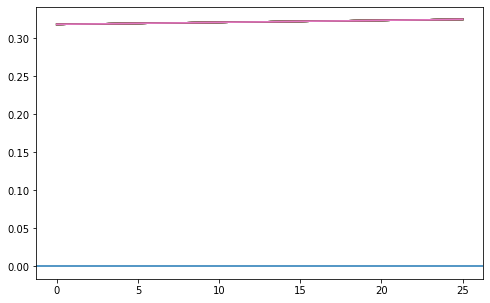

In [257]:
plt.plot(B1[:, -1, :])
plt.axhline(0)
plt.show()

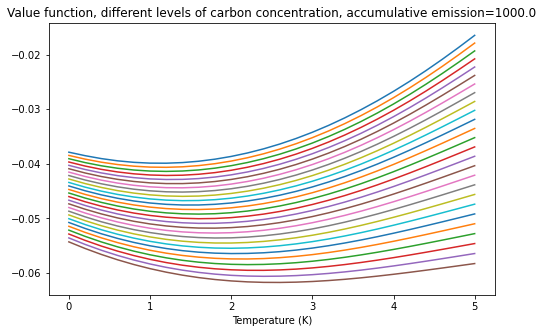

In [258]:
ii = -1
plt.plot(T_grid, v0[:, :, ii])
plt.xlabel("Temperature (K)")
plt.title("Value function, different levels of carbon concentration, accumulative emission={}".format(F_grid[ii]))
plt.show()

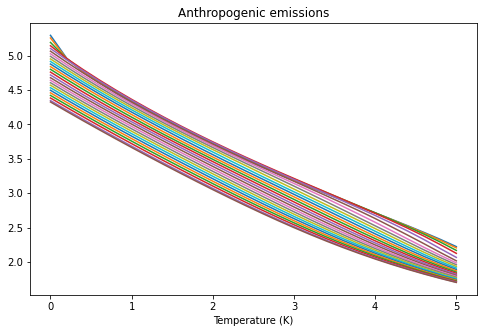

In [259]:
plt.plot(T_grid, Ca[:, :, ii])
plt.xlabel("Temperature (K)")
plt.title("Anthropogenic emissions")
plt.show()

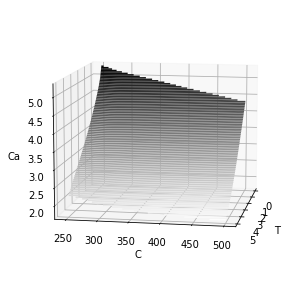

In [260]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(T_mat[:, :, 10], C_mat[:, :, 10], Ca[:, :, ii], 90, cmap='binary')
ax.set_xlabel('T')
ax.set_ylabel('C')
ax.set_zlabel('Ca')
ax.view_init(10, 10)

In [261]:
t_max = 100.
dt = 1/12
gridpoints = (T_grid, C_grid, F_grid)   
Ca_func = RegularGridInterpolator(gridpoints, Ca)

T_0 = To + 1.1
C_0 = 275.5
F_0 = 408.45

def get_e(x):
    return Ca_func([x[0] - To, x[1], x[2]])

# Ocean albedo
def alphaocean_1d(T):
    if T < Talphaocean_low:
        return alphaocean_max
    elif T < Talphaocean_high:
        return alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return alphaocean_min

# Vegetation growth function
def veggrowth_1d(T):
    if T < Tlow:
        return 0
    if (T >= Tlow) and (T < Topt1):
        return acc / (Topt1 - Tlow) * (T - Tlow)
    if (T >= Topt1) and (T <= Topt2):
        return acc
    if (T > Topt2) and (T < Thigh):
        #return acc
        return acc / (Topt2 - Thigh) * (T - Thigh)
    if T > Thigh:
        #return acc
        return 0

def oceanatmphysflux_1d(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def fracseaice_1d(T):
    if T < Talphaocean_low:
        return 1
    elif T < Talphaocean_high:
        return 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return 0

def biopump_1d(Cc):
    if Cc < Cbio_low:
        return 1
    elif Cc < Cbio_high:
        return 1 - 1 / (Cbio_high - Cbio_low) * (Cc - Cbio_low)
    else: 
        return 0


def oceanbioflux_1d(T, F, sa):
     return 1/tauc * (coc0 * (np.exp(bB * biopump_1d(F) * (T - T0))))

def oceanatmcorrflux_1d(C):
    return 1 / tauc * (- cod * C)


def mu_T(x):
    Ri_t = 1 / cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(x[0])))
    Ro_t = 1 / cearth * (kappa * (x[0] - Tkappa) -  B * np.log(x[1] / C0))
    return Ri_t - Ro_t

def mu_C(x):
    Ca_t = Ca_func([x[0] - To, x[1], x[2]])
    dC = Volcan
    dC += Ca_t * sa
    dC -= wa * x[1] * vegcover * veggrowth_1d(x[0])
    dC += oceanatmphysflux_1d(x[0]) * (1 - fracseaice_1d(x[0]))
    dC += oceanbioflux_1d(x[0], x[2], sa) * (1 - fracseaice_1d(x[0]))
    dC += oceanatmcorrflux_1d(x[1]) * (1 - fracseaice_1d(x[0]))
    return dC

def mu_Sa(x):
    return Ca_func([x[0] - To, x[1], x[2]])

years  = np.arange(0, t_max + dt, dt)
pers   = len(years)

hist      = np.zeros([pers, 3])
e_hist    = np.zeros([pers])


for tm in range(pers):
    if tm == 0:
        # initial points
        hist[0,:] = [T_0, C_0, F_0] # logL
        e_hist[0] = get_e(hist[0, :])

    else:
        # other periods
        e_hist[tm] = get_e(hist[tm-1,:])

        hist[tm,0] = max(hist[tm-1,0] + mu_T(hist[tm-1,:]) * dt, To)
        hist[tm,1] = hist[tm-1,1] + mu_C(hist[tm-1,:]) * dt
        hist[tm,2] = hist[tm-1,2] + mu_Sa(hist[tm-1,:]) * dt


Text(0.5, 1.0, '$S_a$')

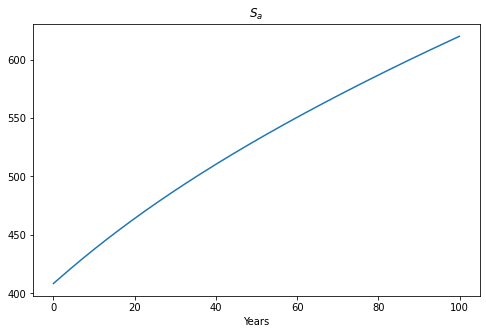

In [262]:
plt.plot(years[:-1], hist[:-1, 2])
plt.xlabel("Years")
plt.title("$S_a$")

Text(0.5, 1.0, 'Emission')

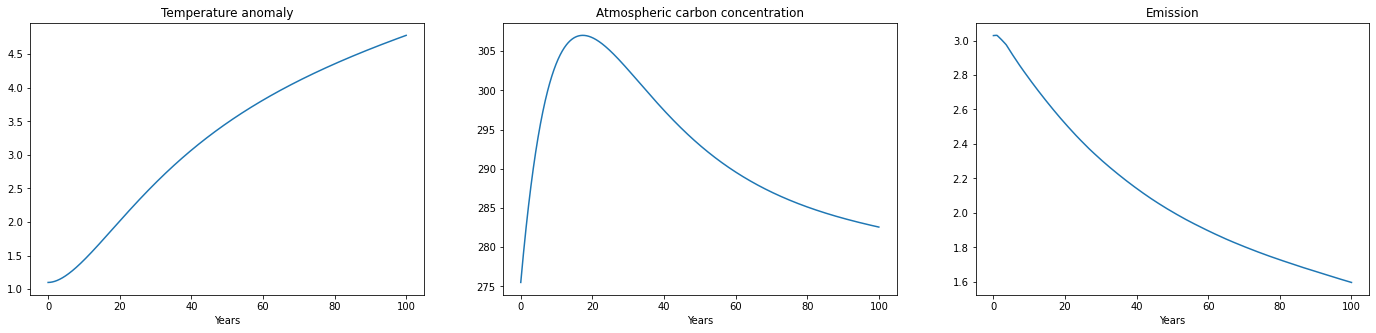

In [263]:
plt.subplots(1,3, figsize=(24,5))
plt.subplot(131)
plt.plot(years, hist[:, 0] - To)
plt.xlabel("Years")
plt.title("Temperature anomaly")
plt.subplot(132)
plt.plot(years, hist[:, 1])
plt.xlabel("Years")
plt.title("Atmospheric carbon concentration")
plt.subplot(133)
plt.plot(years, e_hist)
plt.xlabel("Years")
plt.title("Emission")